In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## Imports 

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
from torchsummary import summary 
import onnx 
import onnxruntime as ort
from sklearn.metrics import precision_score, recall_score, f1_score
import random
import os
import datetime
import matplotlib.pyplot as plt

## Dataset Class 

In [4]:
class SaliencyDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

## Data Loaders

In [5]:
def get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(256,256),
    split_ratio=(0.8,0.1,0.1),
    batch_sizes=(64,16,16),
    random_state=42
):
    """
    Create train/val/test DataLoaders given lists of image and mask directories.

    Args:
      image_dirs, mask_dirs: lists of folder paths (must be same length)
      input_size: tuple for Resize
      split_ratio: fractions for train, val, test (must sum to 1)
      batch_sizes: batch sizes for train, val, test loaders
      random_state: seed for reproducibility

    Returns:
      train_loader, val_loader, test_loader
    Prints dataset sizes.
    """
    # Collect file lists
    image_files, mask_files = [], []
    for img_dir, msk_dir in zip(image_dirs, mask_dirs):
        imgs = sorted([os.path.join(img_dir,f) for f in os.listdir(img_dir)
                      if f.lower().endswith(('.jpg','.png'))])
        msks = sorted([os.path.join(msk_dir,f) for f in os.listdir(msk_dir)
                      if f.lower().endswith(('.jpg','.png'))])
        assert len(imgs)==len(msks), f"Mismatch in {img_dir}"
        image_files.extend(imgs)
        mask_files.extend(msks)

    # Train/val/test split
    from sklearn.model_selection import train_test_split
    train_ratio, val_ratio, test_ratio = split_ratio
    train_imgs, temp_imgs, train_msks, temp_msks = train_test_split(
        image_files, mask_files, test_size=(1-train_ratio), random_state=random_state)
    val_prop = val_ratio/(val_ratio+test_ratio)
    val_imgs, test_imgs, val_msks, test_msks = train_test_split(
        temp_imgs, temp_msks, test_size=(1-val_prop), random_state=random_state)

    print(f"Total images: {len(image_files)}")
    print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

    # Transforms and Dataset
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor()
    ])

    train_ds = SaliencyDataset(train_imgs, train_msks, transform)
    val_ds   = SaliencyDataset(val_imgs,   val_msks,   transform)
    test_ds  = SaliencyDataset(test_imgs,  test_msks,  transform)

    train_loader = DataLoader(train_ds, batch_size=batch_sizes[0], shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_sizes[1], shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_sizes[2], shuffle=False)

    return train_loader, val_loader, test_loader


## Defined Model 

In [6]:
class Saliency_IR_v1(nn.Module):
    def __init__(self):
        super(Saliency_IR_v1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Quantitative Evaluation Function

In [7]:
def evaluate_quantitative(model, dataloader, device, bin_thresh=0.5, beta2=0.3):
    mae_sum = 0.0
    prec_sum = 0.0
    rec_sum  = 0.0
    iou_list = []
    n = 0

    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images).cpu().numpy()
            gts     = masks.cpu().numpy()

            for pred, gt in zip(outputs, gts):
                pred = pred[0]
                gt   = gt[0]
                # MAE
                mae_sum += np.mean(np.abs(pred - gt))
                # Binarize
                pbin = (pred >= bin_thresh).astype(np.uint8)
                gbin = (gt   >= bin_thresh).astype(np.uint8)
                # Precision/Recall
                tp = (pbin & gbin).sum()
                fp = (pbin & (1-gbin)).sum()
                fn = ((1-pbin) & gbin).sum()
                prec_sum += tp / (tp + fp + 1e-8)
                rec_sum  += tp / (tp + fn + 1e-8)
                # IoU
                inter = (pbin & gbin).sum()
                union = (pbin | gbin).sum()
                iou_list.append(inter/union if union>0 else float(inter==0))
                n += 1

    mae       = mae_sum / n
    precision = prec_sum / n
    recall    = rec_sum / n
    fbeta     = (1+beta2)*precision*recall/(beta2*precision+recall+1e-8)
    miou      = np.mean(iou_list)

    print("\nQuantitative Evaluation:")
    print(f"MAE            : {mae:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"Fβ (β²={beta2}): {fbeta:.4f}")
    print(f"Mean IoU       : {miou:.4f}")

    return {"mae":mae, "precision":precision, "recall":recall, "f_beta":fbeta, "miou":miou}

## Object Presence Recall Function

In [8]:
def evaluate_object_presence(model, dataloader, device, bin_thresh=0.5, pixel_fraction=0.001):
    tp, fn = 0, 0
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images).cpu().numpy()
            gts     = masks.cpu().numpy()

            for pred, gt in zip(outputs, gts):
                p_map = pred[0]
                gt_map = gt[0]
                # Binarize
                pbin = (p_map >= bin_thresh).astype(np.uint8)
                gbin = (gt_map >= bin_thresh).astype(np.uint8)
                # Fraction
                frac_pred = pbin.sum() / pbin.size
                frac_gt   = gbin.sum() / gbin.size
                # Presence
                obj_pred = frac_pred > pixel_fraction
                obj_gt   = frac_gt   > pixel_fraction
                # Count for recall
                if obj_gt:
                    tp += int(obj_pred)
                    fn += int(not obj_pred)

    recall = tp / (tp + fn + 1e-8)
    print("\nObject Presence Recall:")
    print(f"Recall: {recall:.4f}")
    return recall

## Run Evaluations

In [9]:
# List of folders
image_dirs = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Actual scenario/images",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Bridge data/images",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/test",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/train",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/val",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/simulated/images/norm_ir_8bit",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/images/IR_norm8bit"
]

mask_dirs = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Actual scenario/saliency_masks",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Bridge data/saliency_masks",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/test",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/train",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/val",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/simulated/saliency_masks",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/Saliency_map/IR"
]

# Get loaders
train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(256,256),
    split_ratio=(0.8,0.1,0.1),
    batch_sizes=(64,16,16)
)

Total images: 31566
Train: 25252, Val: 3157, Test: 3157


In [10]:
# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/home/deepaksr/project/Project_files_2/training_logs/fixed_bce_20250508_094203/best_model.pth"

# Load model
model = Saliency_IR_v1().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

/tmp/ipykernel_812101/1150639925.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))


Saliency_IR_v1(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)

### 1 Object presence detection with fixed pixel fraction

In [13]:
# 1. Quantitative metrics
quant_metrics = evaluate_quantitative(model, test_loader, DEVICE)

# 2. Object Presence Recall
obj_recall = evaluate_object_presence(model, test_loader, DEVICE)


Quantitative Evaluation:
MAE            : 0.0214
Precision      : 0.7379
Recall         : 0.5979
Fβ (β²=0.3): 0.7000
Mean IoU       : 0.5897

Object Presence Recall:
Recall: 0.9468


### 2 Object presence detection with pixel fraction computed from dataset

In [13]:
def compute_min_pixel_fraction(dataloader, bin_thresh=0.5):
    """
    Compute the minimum non-zero area fraction across all ground-truth masks.
    binarization uses bin_thresh, but this only drives area fraction computation.
    """
    min_frac = float('inf')
    for _, masks in dataloader:
        m_np = masks.numpy()  # shape (B,1,H,W)
        for m in m_np:
            binary = (m[0] >= bin_thresh).astype(np.uint8)
            total = binary.size
            salient = binary.sum()
            if salient > 0:
                min_frac = min(min_frac, salient/total)
    if min_frac == float('inf'):
        raise RuntimeError("No non-empty masks found.")
    return min_frac

In [14]:
# 2. Object Presence Recall
data_driven_pixel_fraction = compute_min_pixel_fraction(test_loader)
obj_recall = evaluate_object_presence(model, test_loader, DEVICE, 0.5, data_driven_pixel_fraction)


Object Presence Recall:
Recall: 0.9697


In [15]:
def threshold_sweep_analysis(
    model, dataloader, device, thresholds, pixel_fraction, save_dir
):
    os.makedirs(save_dir, exist_ok=True)
    results = []
    for t in thresholds:
        qm = evaluate_quantitative(model, dataloader, device, bin_thresh=t)
        op = evaluate_object_presence(model, dataloader, device, bin_thresh=t, pixel_fraction=pixel_fraction)
        results.append((t, qm['precision'], qm['recall'], qm['f_beta'], qm['miou'], op))
    # Plot each metric vs threshold
    metrics = ['precision','recall','f_beta','miou','obj_recall']
    for idx, name in enumerate(metrics):
        plt.figure()
        vals = [r[idx+1] for r in results]
        plt.plot(thresholds, vals)
        plt.xlabel('Threshold')
        plt.ylabel(name)
        plt.title(f'{name} vs Binarization Threshold')
        plt.grid(True)
        plt.savefig(os.path.join(save_dir, f'{name}_vs_thresh.png'))
        plt.show()
    return results


Quantitative Evaluation:
MAE            : 0.0214
Precision      : 0.5792
Recall         : 0.7744
Fβ (β²=0.3): 0.6150
Mean IoU       : 0.5440

Object Presence Recall:
Recall: 0.9993

Quantitative Evaluation:
MAE            : 0.0214
Precision      : 0.6182
Recall         : 0.7454
Fβ (β²=0.3): 0.6435
Mean IoU       : 0.5710

Object Presence Recall:
Recall: 0.9959

Quantitative Evaluation:
MAE            : 0.0214
Precision      : 0.6496
Recall         : 0.7180
Fβ (β²=0.3): 0.6642
Mean IoU       : 0.5858

Object Presence Recall:
Recall: 0.9884

Quantitative Evaluation:
MAE            : 0.0214
Precision      : 0.6668
Recall         : 0.6957
Fβ (β²=0.3): 0.6733
Mean IoU       : 0.5933

Object Presence Recall:
Recall: 0.9836

Quantitative Evaluation:
MAE            : 0.0214
Precision      : 0.6883
Recall         : 0.6728
Fβ (β²=0.3): 0.6846
Mean IoU       : 0.5984

Object Presence Recall:
Recall: 0.9792

Quantitative Evaluation:
MAE            : 0.0214
Precision      : 0.7053
Recall         :

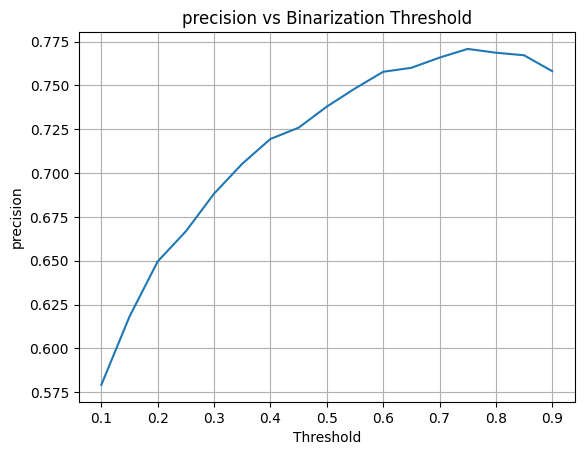

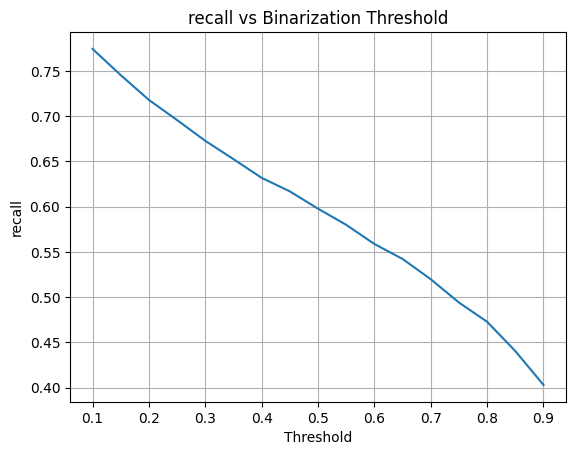

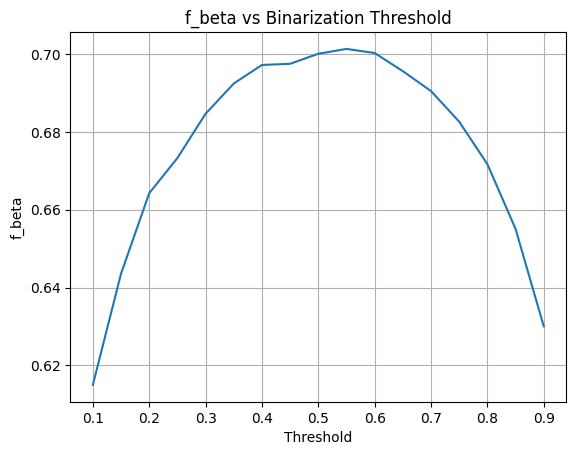

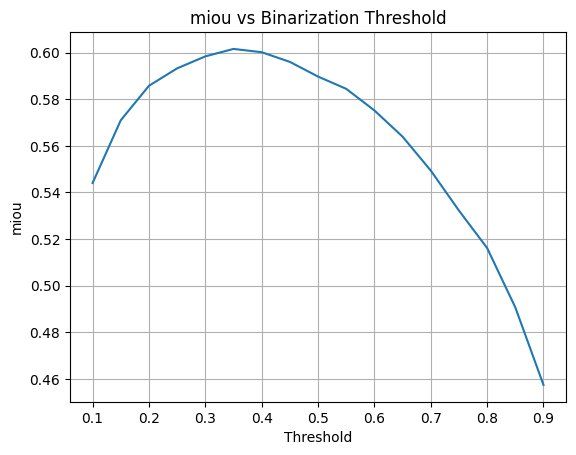

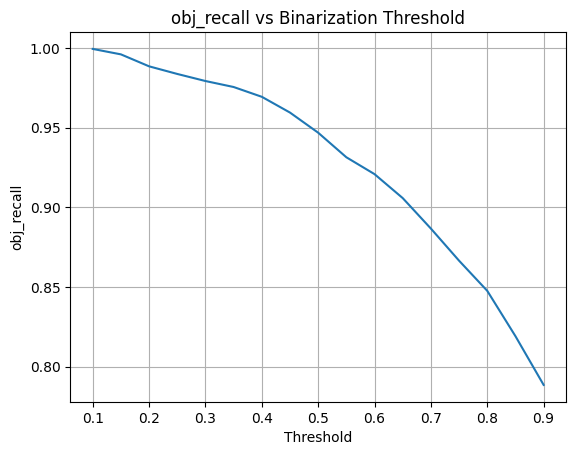

In [16]:
# Execution
thresholds = np.linspace(0.1,0.9,17)
save_dir = 'threshold_analysis'
pixel_fraction = 0.001
sweep_results = threshold_sweep_analysis(model, test_loader, DEVICE, thresholds, pixel_fraction, save_dir)

In [ ]:
metrics = ['precision','recall','f_beta','miou','obj_recall']
best_values = {}
for i, name in enumerate(metrics, start=1):
    # For each metric index i in the tuple
    best_idx = max(range(len(sweep_results)), key=lambda k: sweep_results[k][i])
    best_values[name] = (sweep_results[best_idx][0], sweep_results[best_idx][i])

for name, (th, val) in best_values.items():
    print(f"🎯 Best {name} = {val:.4f} at threshold = {th:.2f}")


Analyzing GT masks:   0%|          | 0/3157 [00:00<?, ?it/s]

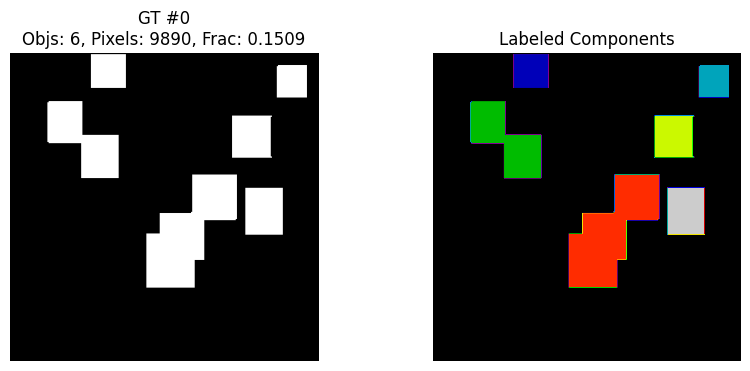

Analyzing GT masks:   0%|          | 1/3157 [00:00<08:29,  6.20it/s]

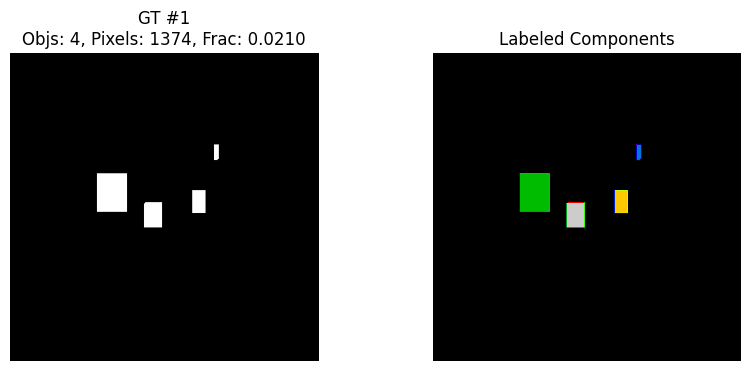

Analyzing GT masks:   0%|          | 2/3157 [00:00<07:21,  7.14it/s]

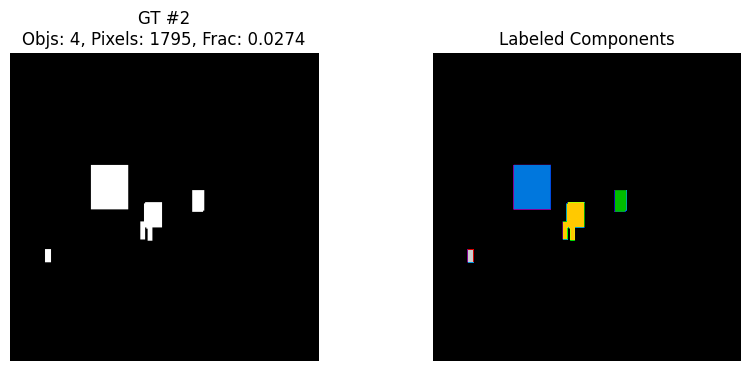

Analyzing GT masks: 100%|██████████| 3157/3157 [00:13<00:00, 228.28it/s]


✅ Saved GT mask stats to gt_mask_stats.csv
🔧 Filtering threshold (5th percentile): 38 px


In [16]:
# %% [markdown]
# Cell 6: Analyze & Verify GT Masks

from skimage import measure
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

# 1) Get your GT mask filepaths from the test loader
gt_paths = test_loader.dataset.mask_paths

# 2) Function to compute stats + return the labeled mask
def get_mask_stats(mask):
    # mask: 2D binary numpy array (0/1)
    lbl = measure.label(mask, connectivity=2)
    props = measure.regionprops(lbl)
    sizes = [p.area for p in props]                  # individual component areas
    total = int(mask.sum())                          # total salient pixels
    frac  = total / mask.size                        # fraction of image
    return len(sizes), sizes, total, frac, lbl

# 3) Loop over GT masks, collect stats and display first few examples
gt_stats = []
for idx, p in enumerate(tqdm(gt_paths, desc="Analyzing GT masks")):
    # load & binarize to match your transforms (256×256, threshold 128)
    img   = Image.open(p).convert("L")
    arr   = np.array(img.resize((256,256)))
    bin_m = (arr >= 128).astype(np.uint8)
    
    # compute stats + labeled-connectivity map
    num_comp, sizes, total_pix, frac_pix, lbl_map = get_mask_stats(bin_m)
    
    # store
    gt_stats.append({
        "mask_path"       : p,
        "num_components"  : num_comp,
        "component_sizes" : sizes,
        "total_salient"   : total_pix,
        "fraction_salient": frac_pix
    })
    
    # visualize the first 3 masks for manual verification
    if idx < 3:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(bin_m, cmap='gray')
        plt.title(f"GT #{idx}\nObjs: {num_comp}, Pixels: {total_pix}, Frac: {frac_pix:.4f}")
        plt.axis('off')
        
        plt.subplot(1,2,2)
        plt.imshow(lbl_map, cmap='nipy_spectral')
        plt.title("Labeled Components")
        plt.axis('off')
        plt.show()

# 4) Save to CSV
gt_stats_df = pd.DataFrame(gt_stats)
gt_stats_df.to_csv("gt_mask_stats.csv", index=False)
print("✅ Saved GT mask stats to gt_mask_stats.csv")

# 5) Decide filter cutoff (e.g. 5th percentile of GT sizes)
all_gt_sizes   = [s for comp in gt_stats_df["component_sizes"] for s in comp]
min_valid_size = int(np.percentile(all_gt_sizes, 5))
print(f"🔧 Filtering threshold (5th percentile): {min_valid_size} px")


Analyzing preds:   0%|          | 0/3157 [00:00<?, ?it/s]

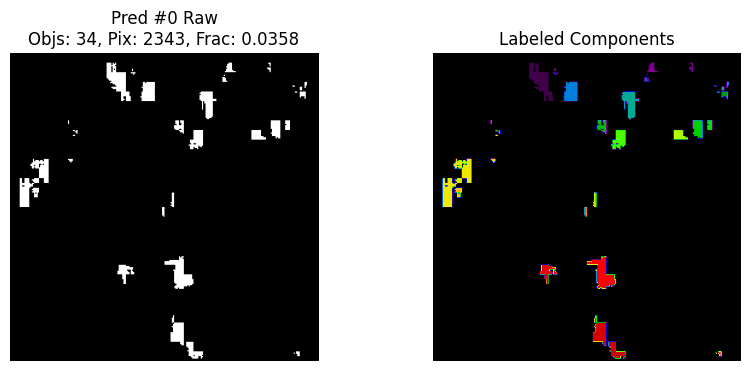

Analyzing preds:   0%|          | 1/3157 [00:00<06:57,  7.55it/s]

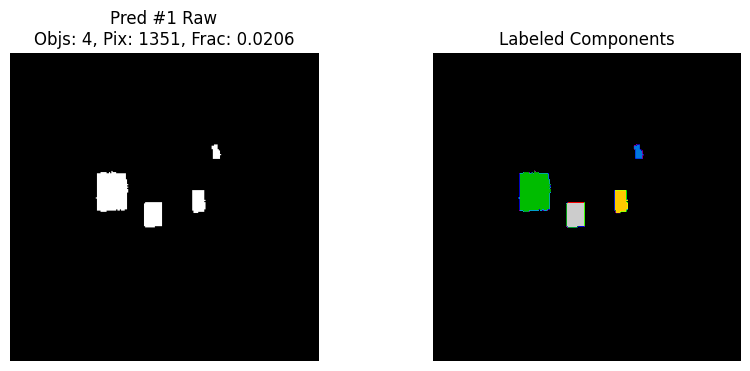

Analyzing preds:   0%|          | 2/3157 [00:00<06:17,  8.37it/s]

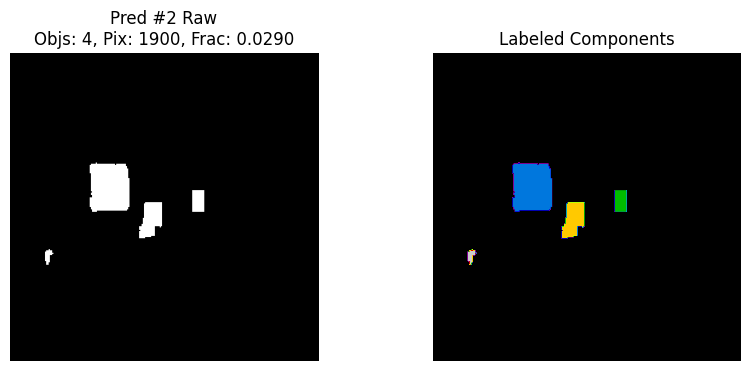

Analyzing preds: 100%|██████████| 3157/3157 [00:03<00:00, 950.37it/s] 

✅ Saved predicted mask stats to pred_mask_stats.csv


In [17]:
# %% [markdown]
# Cell 7: Analyze & Verify Predicted Masks

from skimage import measure
from skimage.morphology import remove_small_objects
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import torch

# 1) Generate & collect raw binary predictions
pred_paths   = []  # optional: if you have filepaths, otherwise index order
pred_bins    = []
with torch.no_grad():
    for imgs, _ in tqdm(test_loader, desc="Running model"):
        outs = model(imgs.to(DEVICE)).cpu().numpy()  # (B,1,H,W)
        for o in outs:
            # raw binarization at 0.5
            pred_bins.append((o[0] >= 0.5).astype(np.uint8))

# 2) Function to compute stats + return labeled mask    
def get_pred_stats(bin_mask, filter_size=None):
    # Optionally remove small objects
    lbl = measure.label(bin_mask, connectivity=2)
    if filter_size:
        lbl = remove_small_objects(lbl, min_size=filter_size)
    props = measure.regionprops(lbl)
    sizes = [p.area for p in props]
    total = int((lbl > 0).sum())
    frac  = total / bin_mask.size
    return len(sizes), sizes, total, frac, lbl

pred_stats = []
for idx, bin_m in enumerate(tqdm(pred_bins, desc="Analyzing preds")):
    # Compute raw stats (no filter)
    num_c, sizes, total_pix, frac_pix, lbl_map = get_pred_stats(bin_m)
    pred_stats.append({
        "idx": idx,
        "component_sizes_raw": sizes,
        "total_salient_raw": total_pix,
        "fraction_salient_raw": frac_pix
    })
    # Display first 3 for verification
    if idx < 3:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(bin_m, cmap='gray')
        plt.title(f"Pred #{idx} Raw\nObjs: {num_c}, Pix: {total_pix}, Frac: {frac_pix:.4f}")
        plt.axis('off')
        
        plt.subplot(1,2,2)
        plt.imshow(lbl_map, cmap='nipy_spectral')
        plt.title("Labeled Components")
        plt.axis('off')
        plt.show()

# 3) Save to CSV
pred_df = pd.DataFrame(pred_stats)
pred_df.to_csv("pred_mask_stats.csv", index=False)
print("✅ Saved predicted mask stats to pred_mask_stats.csv")


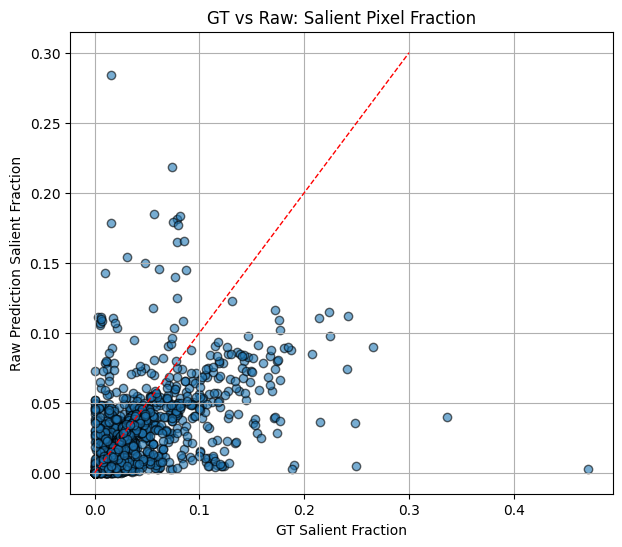

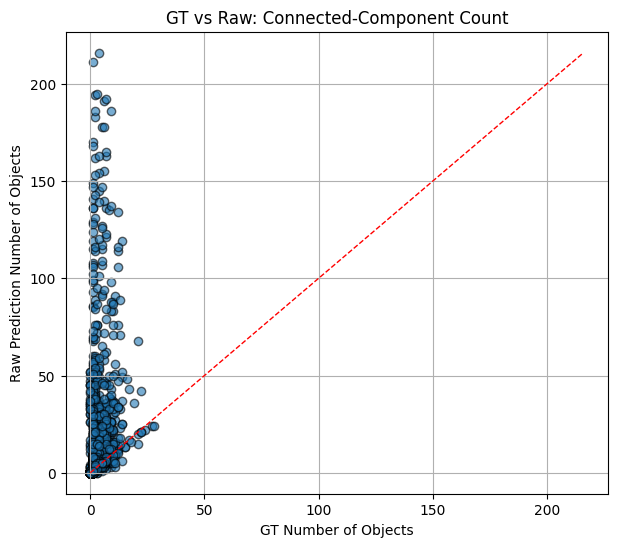

In [24]:
# %% [markdown]
# Cell 8: Compare GT vs Raw Prediction Statistics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load GT and raw prediction stats
gt_df   = pd.read_csv("gt_mask_stats.csv")      # columns: mask_path, num_components, component_sizes, total_salient, fraction_salient
pred_df = pd.read_csv("pred_mask_stats.csv")    # columns: idx, component_sizes_raw, total_salient_raw, fraction_salient_raw

# Merge by index/order: add 'idx' to GT and join
gt_df = gt_df.reset_index().rename(columns={"index": "idx"})
merged = pd.merge(gt_df, pred_df, on="idx")

# Extract values
gt_frac   = merged["fraction_salient"]
raw_frac  = merged["fraction_salient_raw"]
gt_count  = merged["num_components"]
# component_sizes_raw is stored as a list; count its length
raw_count = merged["component_sizes_raw"].apply(lambda x: len(eval(x)) if isinstance(x, str) else len(x))

# 1) Scatter: Salient Fraction
plt.figure(figsize=(7, 6))
plt.scatter(gt_frac, raw_frac, alpha=0.6, edgecolor='k')
plt.plot([0, 0.3], [0, 0.3], "r--", linewidth=1)
plt.xlabel("GT Salient Fraction")
plt.ylabel("Raw Prediction Salient Fraction")
plt.title("GT vs Raw: Salient Pixel Fraction")
plt.grid(True)
plt.show()

# 2) Scatter: Object Count
max_count = max(gt_count.max(), raw_count.max())
plt.figure(figsize=(7, 6))
plt.scatter(gt_count, raw_count, alpha=0.6, edgecolor='k')
plt.plot([0, max_count], [0, max_count], "r--", linewidth=1)
plt.xlabel("GT Number of Objects")
plt.ylabel("Raw Prediction Number of Objects")
plt.title("GT vs Raw: Connected‐Component Count")
plt.grid(True)
plt.show()


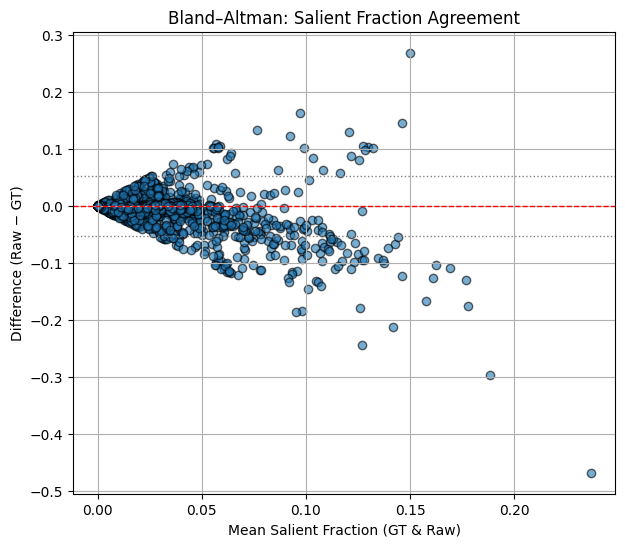

In [20]:
# %% [markdown]
# Cell 8-continued: Bland–Altman Plot for Salient Fraction

# Compute mean and difference
mean_frac = (gt_frac + raw_frac) / 2
diff_frac = raw_frac - gt_frac

plt.figure(figsize=(7,6))
plt.scatter(mean_frac, diff_frac, alpha=0.6, edgecolor='k')
plt.axhline(0, color='r', linestyle='--', linewidth=1)
# Optionally, plot ±1.96×SD lines
sd = np.std(diff_frac)
plt.axhline( 1.96*sd, color='gray', linestyle=':', linewidth=1)
plt.axhline(-1.96*sd, color='gray', linestyle=':', linewidth=1)

plt.xlabel("Mean Salient Fraction (GT & Raw)")
plt.ylabel("Difference (Raw − GT)")
plt.title("Bland–Altman: Salient Fraction Agreement")
plt.grid(True)
plt.show()


/tmp/ipykernel_812101/1548006449.py:15: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  lbl_f = remove_small_objects(lbl, min_size=min_valid_size)


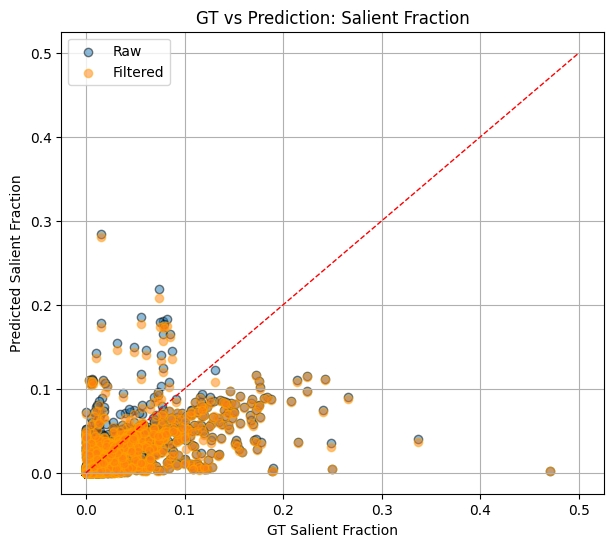

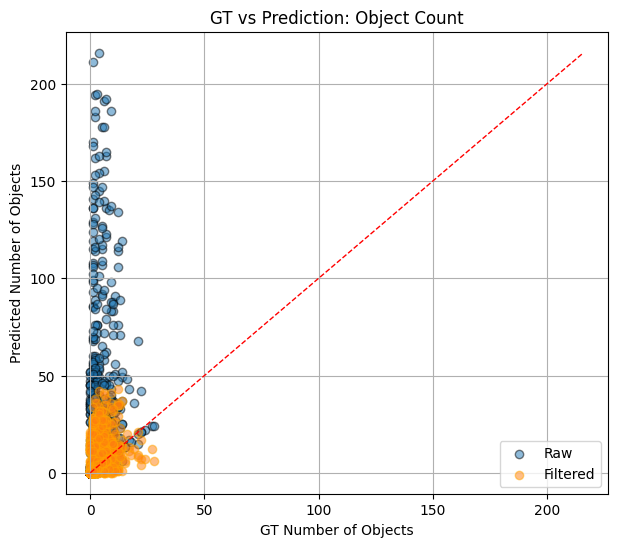

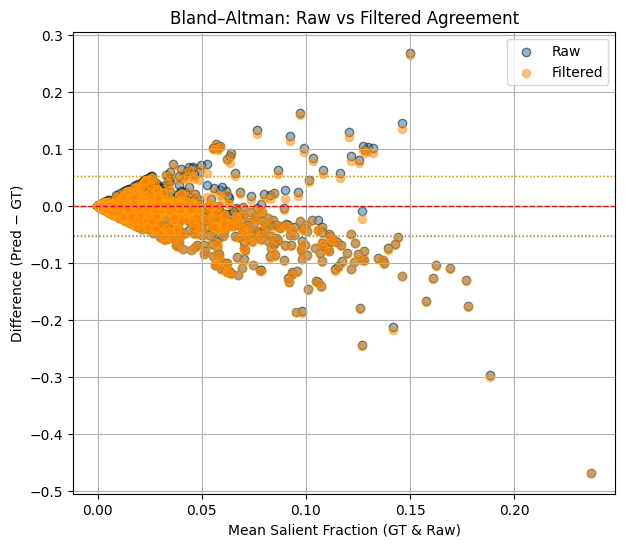

In [22]:
# %% [markdown]
# Cell 8-continued: Apply Filtering & Compare GT vs Raw vs Filtered

from skimage.morphology import remove_small_objects
import numpy as np
import matplotlib.pyplot as plt

# 1) Compute filtered stats from your pred_bins list and the GT-derived min_valid_size
filtered_fracs = []
filtered_counts = []

for bin_pred in pred_bins:
    # label and remove small objects
    lbl = measure.label(bin_pred, connectivity=2)
    lbl_f = remove_small_objects(lbl, min_size=min_valid_size)
    
    # fraction
    total_f = (lbl_f > 0).sum()
    filtered_fracs.append(total_f / bin_pred.size)
    # component count
    filtered_counts.append(len(measure.regionprops(lbl_f)))

# 2) Add filtered stats into your merged DataFrame
merged["fraction_salient_filtered"] = filtered_fracs
merged["num_components_filtered"]    = filtered_counts

# 3) Extract series for plotting
gt_frac   = merged["fraction_salient"]
raw_frac  = merged["fraction_salient_raw"]
filt_frac = merged["fraction_salient_filtered"]

gt_count   = merged["num_components"]
raw_count  = merged["component_sizes_raw"].apply(lambda x: len(eval(x)) if isinstance(x,str) else len(x))
filt_count = merged["num_components_filtered"]

# 4) Plot GT vs Raw vs Filtered salient-fraction
plt.figure(figsize=(7,6))
plt.scatter(gt_frac, raw_frac,   alpha=0.5, label="Raw",      edgecolor='k')
plt.scatter(gt_frac, filt_frac,  alpha=0.5, label="Filtered", edgecolor='orange')
plt.plot([0,0.5],[0,0.5],"r--", linewidth=1)
plt.xlabel("GT Salient Fraction")
plt.ylabel("Predicted Salient Fraction")
plt.title("GT vs Prediction: Salient Fraction")
plt.legend()
plt.grid(True)
plt.show()

# 5) Plot GT vs Raw vs Filtered object-count
max_count = max(gt_count.max(), raw_count.max(), filt_count.max())
plt.figure(figsize=(7,6))
plt.scatter(gt_count, raw_count,   alpha=0.5, label="Raw",      edgecolor='k')
plt.scatter(gt_count, filt_count,  alpha=0.5, label="Filtered", edgecolor='orange')
plt.plot([0,max_count],[0,max_count],"r--", linewidth=1)
plt.xlabel("GT Number of Objects")
plt.ylabel("Predicted Number of Objects")
plt.title("GT vs Prediction: Object Count")
plt.legend()
plt.grid(True)
plt.show()

# 6) Bland–Altman for Raw and Filtered
mean_frac  = (gt_frac + raw_frac)  / 2
diff_raw   = raw_frac  - gt_frac
diff_filt  = filt_frac - gt_frac
sd_raw     = np.std(diff_raw)
sd_filt    = np.std(diff_filt)

plt.figure(figsize=(7,6))
plt.scatter(mean_frac, diff_raw,  alpha=0.5, label="Raw",      edgecolor='k')
plt.scatter(mean_frac, diff_filt, alpha=0.5, label="Filtered", edgecolor='orange')
plt.axhline(0, color='r', linestyle='--', linewidth=1)
plt.axhline( 1.96*sd_raw, color='gray',   linestyle=':', linewidth=1)
plt.axhline(-1.96*sd_raw, color='gray',   linestyle=':', linewidth=1)
plt.axhline( 1.96*sd_filt, color='orange',linestyle=':', linewidth=1)
plt.axhline(-1.96*sd_filt, color='orange',linestyle=':', linewidth=1)
plt.xlabel("Mean Salient Fraction (GT & Raw)")
plt.ylabel("Difference (Pred − GT)")
plt.title("Bland–Altman: Raw vs Filtered Agreement")
plt.legend()
plt.grid(True)
plt.show()


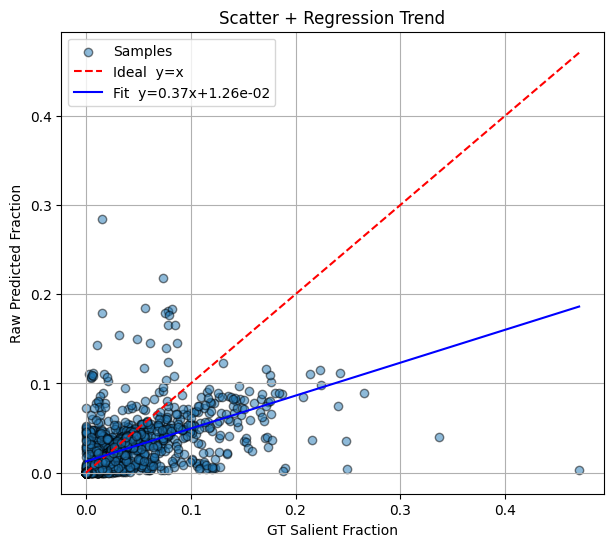

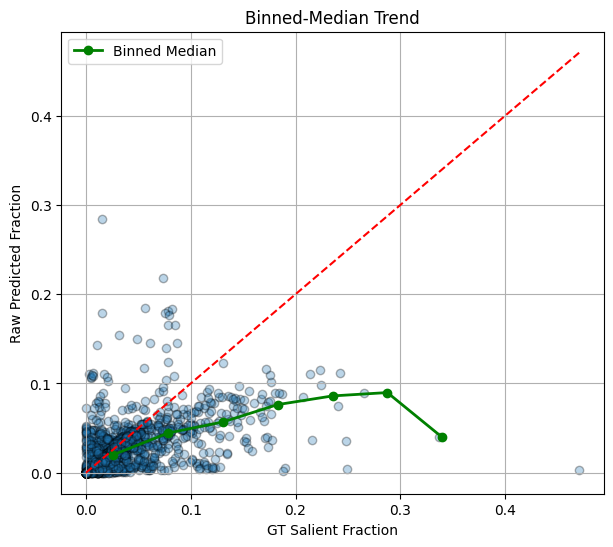

In [23]:
# %% [markdown]
# Cell 8-extra: Trendline & Binned Median on Fraction Scatter

import numpy as np
import matplotlib.pyplot as plt

# gt_frac & raw_frac are from your merged DataFrame
# If not in scope, re-extract:
# gt_frac  = merged["fraction_salient"]
# raw_frac = merged["fraction_salient_raw"]

# 1) Linear regression fit
m, b = np.polyfit(gt_frac, raw_frac, 1)
x_line = np.linspace(0, gt_frac.max(), 100)
y_line = m*x_line + b

plt.figure(figsize=(7,6))
plt.scatter(gt_frac, raw_frac, alpha=0.5, edgecolor='k', label='Samples')
plt.plot(x_line, x_line,      'r--', label='Ideal  y=x')
plt.plot(x_line, y_line,     'b-',  label=f'Fit  y={m:.2f}x+{b:.2e}')
plt.xlabel("GT Salient Fraction")
plt.ylabel("Raw Predicted Fraction")
plt.title("Scatter + Regression Trend")
plt.legend()
plt.grid(True)
plt.show()

# 2) Binned median curve
bin_edges = np.linspace(0, gt_frac.max(), 10)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
medians = []
for lo, hi in zip(bin_edges[:-1], bin_edges[1:]):
    mask = (gt_frac >= lo) & (gt_frac < hi)
    if mask.any():
        medians.append(raw_frac[mask].median())
    else:
        medians.append(np.nan)

plt.figure(figsize=(7,6))
plt.scatter(gt_frac, raw_frac, alpha=0.3, edgecolor='k')
plt.plot(bin_centers, medians, 'g-o', linewidth=2, label='Binned Median')
plt.plot([0, gt_frac.max()], [0, gt_frac.max()], 'r--')
plt.xlabel("GT Salient Fraction")
plt.ylabel("Raw Predicted Fraction")
plt.title("Binned-Median Trend")
plt.legend()
plt.grid(True)
plt.show()


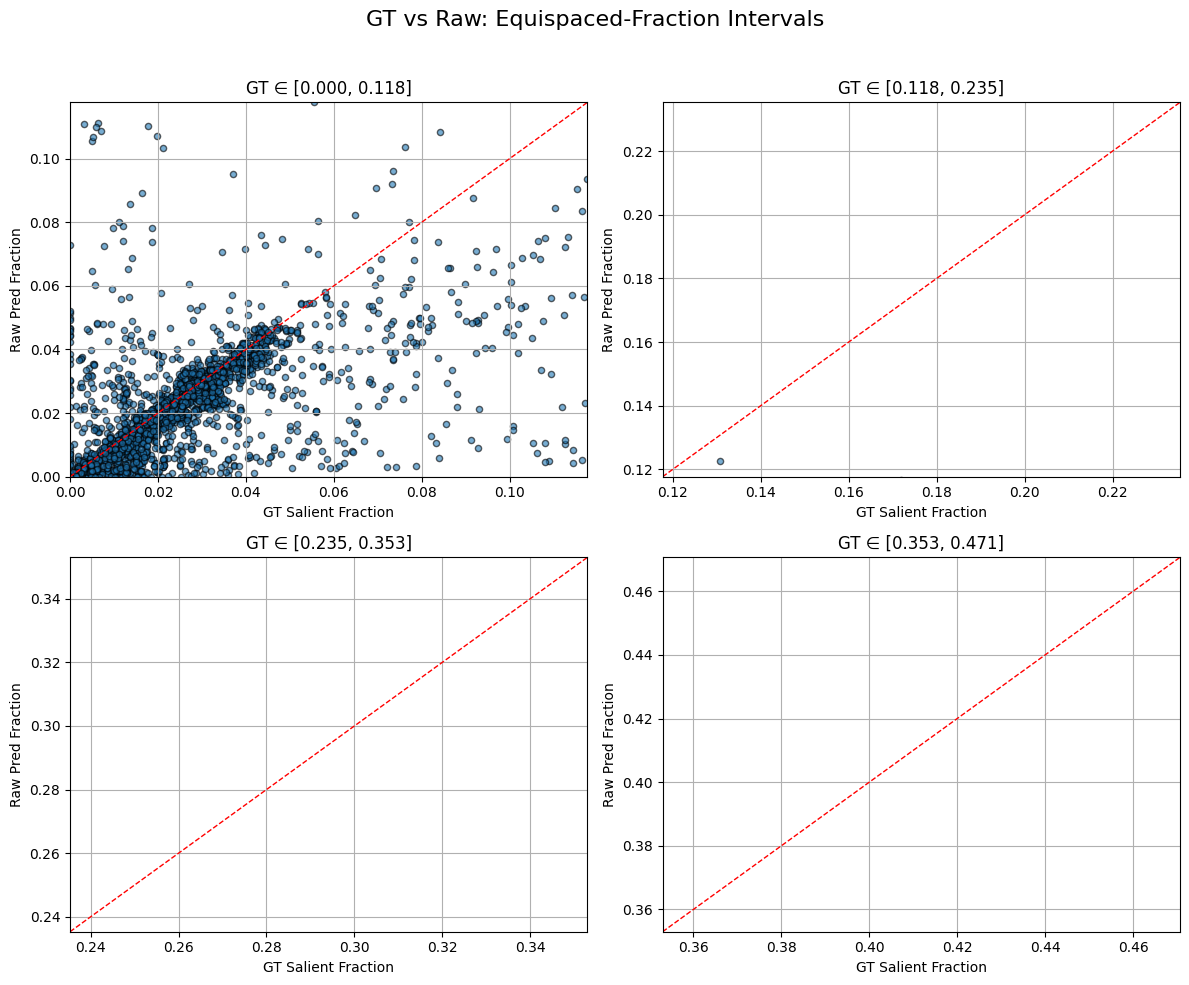

In [26]:
# %% [markdown]
# Cell 9: Equispaced-Quartile Scatter of GT vs Raw Salient Fraction

import numpy as np
import matplotlib.pyplot as plt

# Ensure gt_frac & raw_frac are in scope
# gt_frac  = merged["fraction_salient"]
# raw_frac = merged["fraction_salient_raw"]

fmin, fmax = gt_frac.min(), gt_frac.max()
# Create 5 equally spaced breakpoints from fmin to fmax
cuts = np.linspace(fmin, fmax, 5)

fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.ravel()

for i in range(4):
    lo, hi = cuts[i], cuts[i+1]
    mask = (gt_frac >= lo) & (gt_frac < hi) if i < 3 else (gt_frac >= lo) & (gt_frac <= hi)
    ax = axes[i]
    ax.scatter(gt_frac[mask], raw_frac[mask], alpha=0.6, s=20, edgecolor='k')
    ax.plot([lo, hi], [lo, hi], 'r--', linewidth=1)
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.set_title(f"GT ∈ [{lo:.3f}, {hi:.3f}]")
    ax.set_xlabel("GT Salient Fraction")
    ax.set_ylabel("Raw Pred Fraction")
    ax.grid(True)

fig.suptitle("GT vs Raw: Equispaced-Fraction Intervals", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


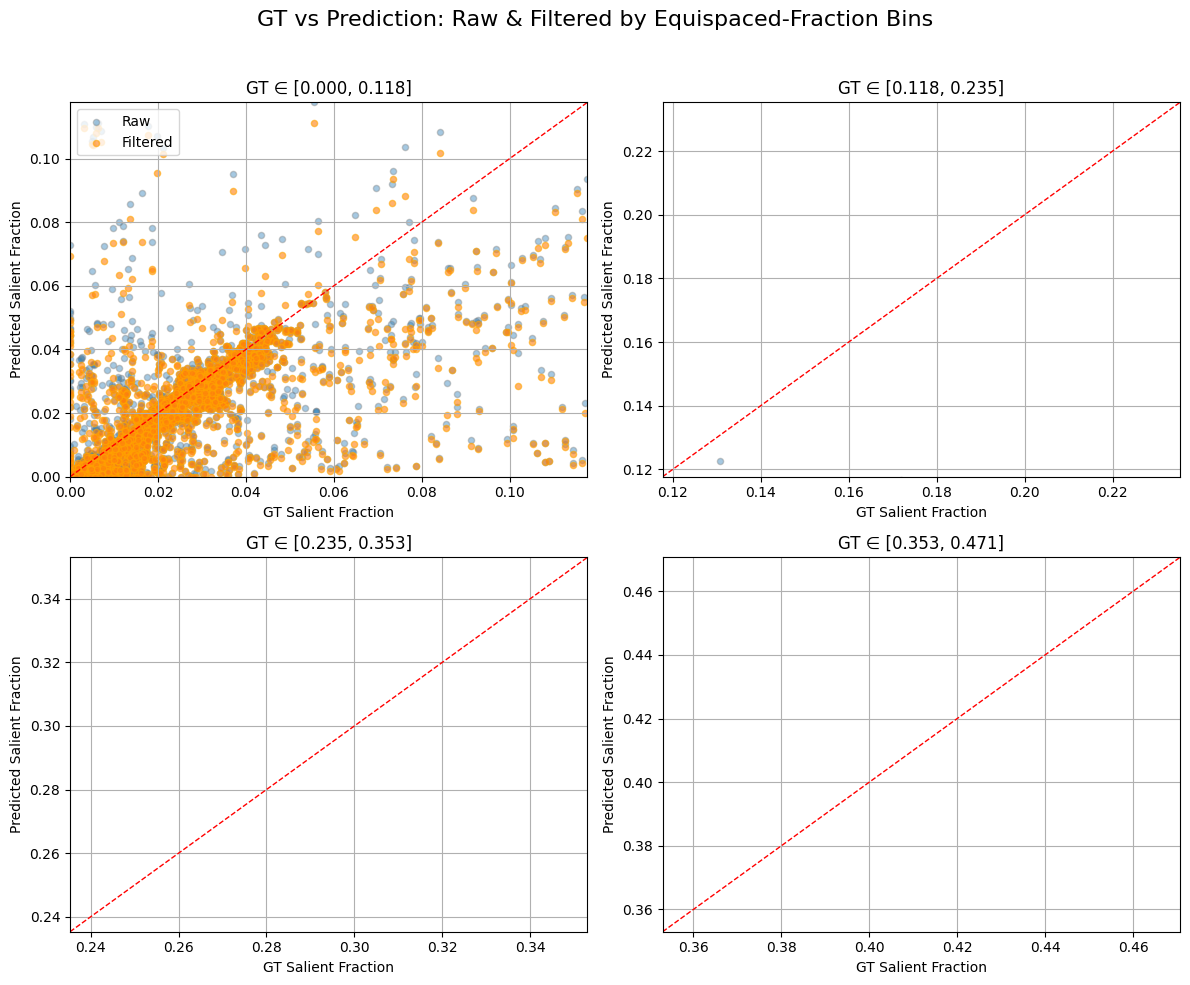

In [27]:
# %% [markdown]
# Cell 10: Equispaced-Quartile Scatter of GT vs Filtered Salient Fraction

import numpy as np
import matplotlib.pyplot as plt

# Ensure these Series exist:
# gt_frac   = merged["fraction_salient"]
# raw_frac  = merged["fraction_salient_raw"]
# filt_frac = merged["fraction_salient_filtered"]

# Recompute cuts or reuse from previous cell
fmin, fmax = gt_frac.min(), gt_frac.max()
cuts = np.linspace(fmin, fmax, 5)

fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.ravel()

for i in range(4):
    lo, hi = cuts[i], cuts[i+1]
    if i < 3:
        mask = (gt_frac >= lo) & (gt_frac < hi)
    else:
        mask = (gt_frac >= lo) & (gt_frac <= hi)

    ax = axes[i]
    # Raw in gray for reference
    ax.scatter(gt_frac[mask], raw_frac[mask],
               alpha=0.4, s=20, edgecolor='gray', label='Raw')
    # Filtered in orange
    ax.scatter(gt_frac[mask], filt_frac[mask],
               alpha=0.6, s=20, edgecolor='orange', label='Filtered')
    # Ideal line
    ax.plot([lo, hi], [lo, hi], 'r--', linewidth=1)
    
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.set_title(f"GT ∈ [{lo:.3f}, {hi:.3f}]")
    ax.set_xlabel("GT Salient Fraction")
    ax.set_ylabel("Predicted Salient Fraction")
    ax.grid(True)
    if i == 0:
        ax.legend(loc='upper left')

fig.suptitle("GT vs Prediction: Raw & Filtered by Equispaced-Fraction Bins", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


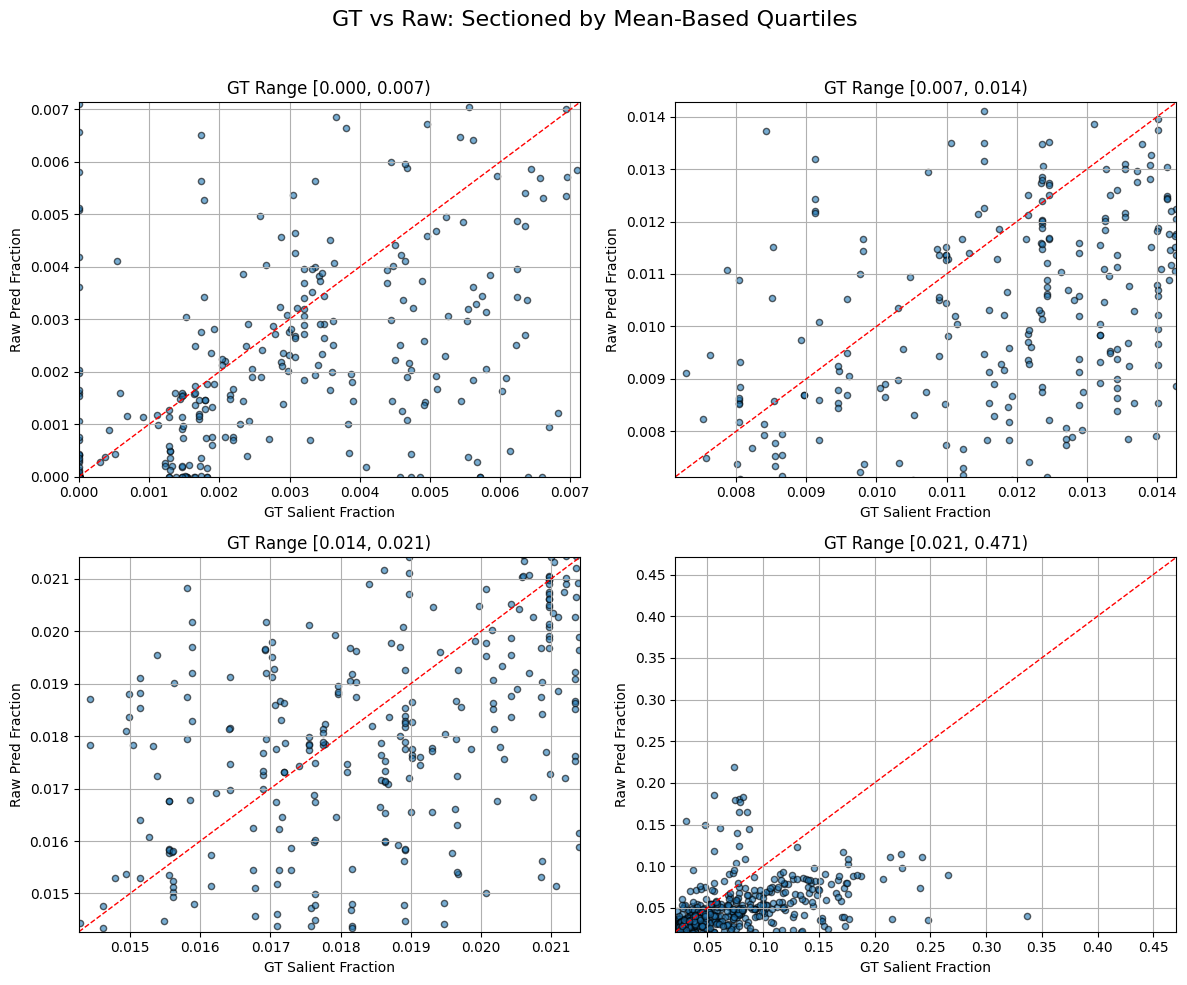

In [25]:
# %% [markdown]
# Cell 9: Sectioned Scatter Plots of GT vs Raw Salient Fraction

import numpy as np
import matplotlib.pyplot as plt

# Assume merged, gt_frac, raw_frac are already in scope
# gt_frac = merged["fraction_salient"]
# raw_frac = merged["fraction_salient_raw"]

M = gt_frac.mean()
max_f = gt_frac.max()
bins = [0, M/4, M/2, 3*M/4, max_f + 1e-6]  # tiny epsilon to include max

fig, axes = plt.subplots(2, 2, figsize=(12,10), sharex=False, sharey=False)
axes = axes.flatten()

for i in range(4):
    lo, hi = bins[i], bins[i+1]
    mask = (gt_frac >= lo) & (gt_frac < hi)
    ax = axes[i]
    ax.scatter(gt_frac[mask], raw_frac[mask],
               alpha=0.6, s=20, edgecolor='k')
    ax.plot([lo, hi], [lo, hi], 'r--', linewidth=1)
    ax.set_xlim(lo, hi)
    # Y-axis scaled to roughly same span, but you can adjust
    ax.set_ylim(lo, hi)
    ax.set_title(f"GT Range [{lo:.3f}, {hi:.3f})")
    ax.set_xlabel("GT Salient Fraction")
    ax.set_ylabel("Raw Pred Fraction")
    ax.grid(True)

fig.suptitle("GT vs Raw: Sectioned by Mean-Based Quartiles", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


In [11]:
# Cell 6: Analyze GT Masks Stats

from skimage import measure
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image

# Reconstruct GT mask paths in test split
gt_paths = test_loader.dataset.mask_paths

def get_mask_stats(mask):
    lbl = measure.label(mask, connectivity=2)
    props = measure.regionprops(lbl)
    sizes = [p.area for p in props]
    total = mask.sum()
    frac = total / mask.size
    return {
        "num_components": len(sizes),
        "component_sizes": sizes,
        "total_salient": total,
        "fraction_salient": frac
    }

gt_stats = []
for p in tqdm(gt_paths, desc="Analyzing GT masks"):
    img = Image.open(p).convert("L")
    arr = np.array(img.resize((256,256)))  # match your transforms
    bin_m = (arr >= 128).astype(np.uint8)
    stats = get_mask_stats(bin_m)
    stats["mask_path"] = p
    gt_stats.append(stats)

gt_stats_df = pd.DataFrame(gt_stats)
gt_stats_df.to_csv("gt_mask_stats.csv", index=False)
print("Saved GT mask stats to gt_mask_stats.csv")

# Decide filter threshold—say 5th percentile of GT sizes
all_gt_sizes = [s for comp in gt_stats_df["component_sizes"] for s in comp]
min_valid_size = int(np.percentile(all_gt_sizes, 5))
print(f"Filtering threshold (min component size): {min_valid_size} px")


Analyzing GT masks: 100%|██████████| 3157/3157 [00:13<00:00, 231.30it/s]

Saved GT mask stats to gt_mask_stats.csv
Filtering threshold (min component size): 38 px


In [12]:
# %% [markdown]
# Cell 7: Analyze Predicted Masks Stats (Raw & Filtered)

from skimage import measure
from skimage.morphology import remove_small_objects
import pandas as pd
import numpy as np
from tqdm import tqdm

# Step 1: Run model and collect binary predictions
pred_bins = []
with torch.no_grad():
    for imgs, _ in tqdm(test_loader, desc="Running model"):
        outs = model(imgs.to(DEVICE)).cpu().numpy()  # (B,1,H,W)
        for o in outs:
            pred_bins.append((o[0] >= 0.5))     # raw binarization

# Step 2: Compute stats for raw & filtered preds
raw_stats, filt_stats = [], []
for idx, bin_pred in enumerate(tqdm(pred_bins, desc="Analyzing preds")):
    # raw connected components
    lbl_raw = measure.label(bin_pred, connectivity=2)
    sizes_raw = [p.area for p in measure.regionprops(lbl_raw)]
    total_raw = bin_pred.sum()
    frac_raw  = total_raw / bin_pred.size

    # filtered
    lbl_f = remove_small_objects(lbl_raw, min_size=min_valid_size)
    sizes_f = [p.area for p in measure.regionprops(lbl_f)]
    total_f = (lbl_f > 0).sum()
    frac_f  = total_f / bin_pred.size

    raw_stats.append({
        "idx": idx,
        "component_sizes_raw": sizes_raw,
        "total_salient_raw": total_raw,
        "fraction_salient_raw": frac_raw
    })
    filt_stats.append({
        "idx": idx,
        "component_sizes_filtered": sizes_f,
        "total_salient_filtered": total_f,
        "fraction_salient_filtered": frac_f
    })

df_raw  = pd.DataFrame(raw_stats)
df_filt = pd.DataFrame(filt_stats)
pred_df = pd.merge(df_raw, df_filt, on="idx")
pred_df.to_csv("pred_mask_stats.csv", index=False)
print("Saved predicted mask stats to pred_mask_stats.csv")


Analyzing preds:   0%|          | 0/3157 [00:00<?, ?it/s]/tmp/ipykernel_812101/1575059804.py:28: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  lbl_f = remove_small_objects(lbl_raw, min_size=min_valid_size)
Analyzing preds: 100%|██████████| 3157/3157 [00:06<00:00, 485.32it/s]


Saved predicted mask stats to pred_mask_stats.csv


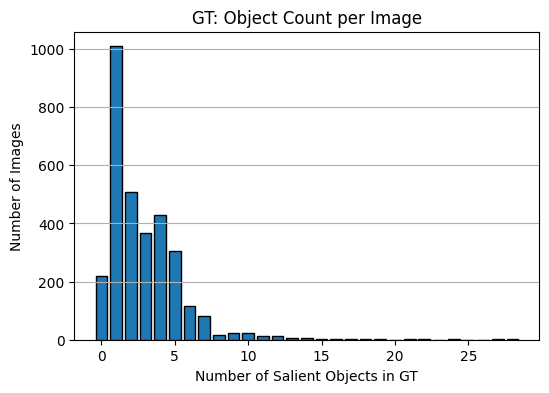

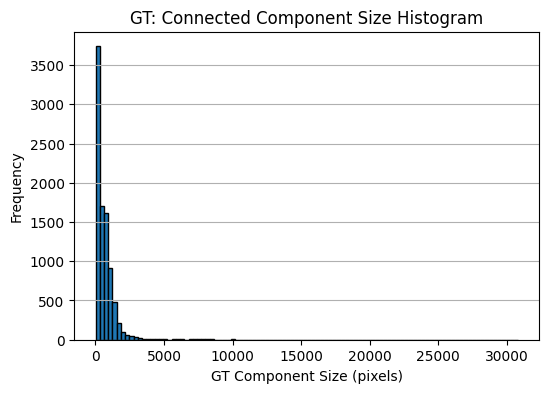

In [15]:
# %% [markdown]
# Cell 9: GT Mask Statistics

import numpy as np
import matplotlib.pyplot as plt

# Helper to flatten list‐of‐lists
def flatten_list(col):
    return np.concatenate(col.apply(lambda x: x if isinstance(x, list) else eval(x)).values)

# 1) Number of components per image (GT)
num_objs_per_img = gt_stats_df["num_components"]
counts, bins = np.histogram(num_objs_per_img, bins=range(0, num_objs_per_img.max()+2))
plt.figure(figsize=(6,4))
plt.bar(bins[:-1], counts, width=0.8, edgecolor='k')
plt.xlabel("Number of Salient Objects in GT")
plt.ylabel("Number of Images")
plt.title("GT: Object Count per Image")
plt.grid(axis='y')
plt.show()

# 2) Component size distribution (GT)
gt_sizes = flatten_list(gt_stats_df["component_sizes"])
plt.figure(figsize=(6,4))
plt.hist(gt_sizes, bins=100, edgecolor='k')
plt.xlabel("GT Component Size (pixels)")
plt.ylabel("Frequency")
plt.title("GT: Connected Component Size Histogram")
plt.grid(axis='y')
plt.show()


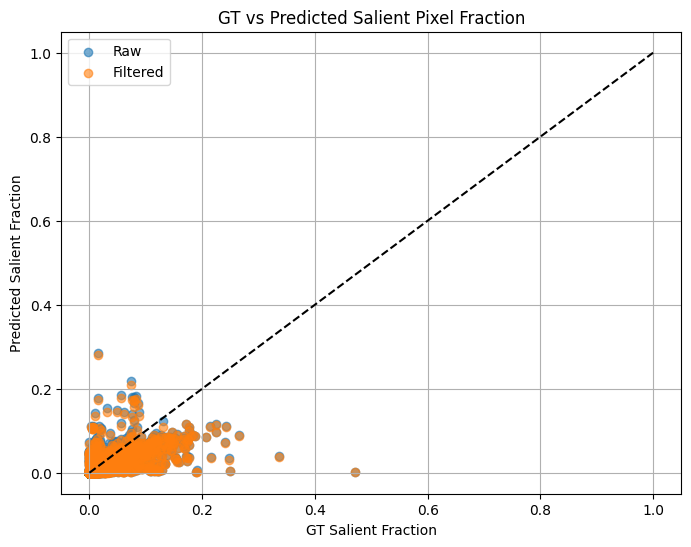

/tmp/ipykernel_785740/1598691050.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([gt_frac, raw_frac, filt_frac],


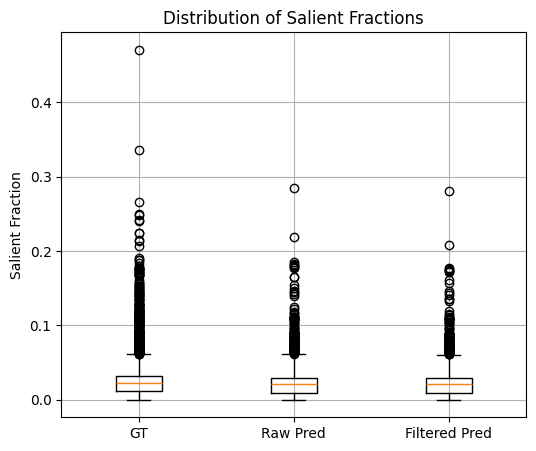

In [ ]:
# Cell 9: Visualize Salient Fraction Stats from CSVs (by index)

import pandas as pd
import matplotlib.pyplot as plt

# Load CSVs
gt_df   = pd.read_csv("gt_mask_stats.csv")
pred_df = pd.read_csv("pred_mask_stats.csv")

# Align by row order
gt_frac   = gt_df["fraction_salient"].reset_index(drop=True)
raw_frac  = pred_df["fraction_salient_raw"].reset_index(drop=True)
filt_frac = pred_df["fraction_salient_filtered"].reset_index(drop=True)

# Scatter: GT vs Predicted Fractions
plt.figure(figsize=(8,6))
plt.scatter(gt_frac, raw_frac,   label="Raw",      alpha=0.6)
plt.scatter(gt_frac, filt_frac,  label="Filtered", alpha=0.6)
plt.plot([0,1],[0,1],"k--")
plt.xlabel("GT Salient Fraction")
plt.ylabel("Predicted Salient Fraction")
plt.title("GT vs Predicted Salient Pixel Fraction")
plt.legend()
plt.grid(True)
plt.show()

# Boxplot: distributions of fractions
plt.figure(figsize=(6,5))
plt.boxplot([gt_frac, raw_frac, filt_frac],
            labels=["GT","Raw Pred","Filtered Pred"])
plt.ylabel("Salient Fraction")
plt.title("Distribution of Salient Fractions")
plt.grid(True)
plt.show()


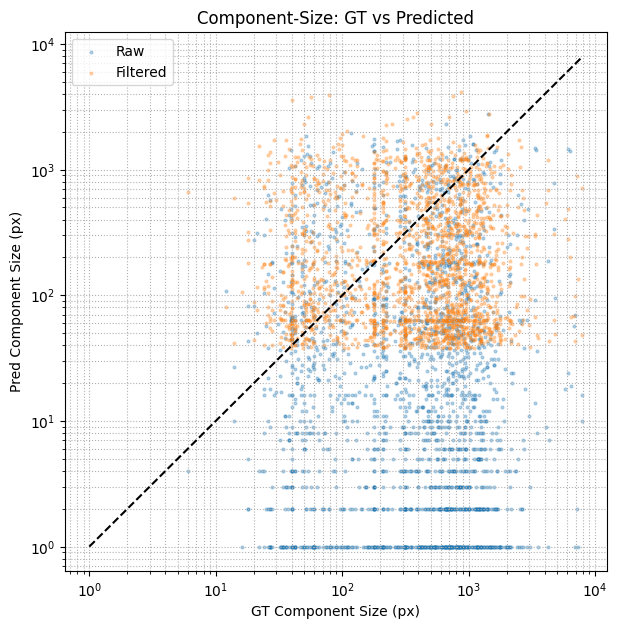

/tmp/ipykernel_785740/1588857664.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([gt_sizes, raw_sizes, filt_sizes],


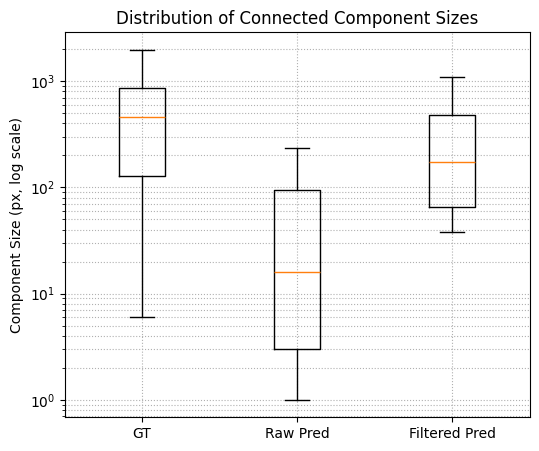

In [ ]:
# Cell 10: Component-Size Comparison (Scatter & Boxplot)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Helper to flatten list-of-lists stored as strings or lists
def flatten_series(ser):
    # If stored as strings like "[10,20,...]", eval; else assume it’s already a list
    lists = ser.apply(lambda x: eval(x) if isinstance(x, str) else x)
    return np.concatenate(lists.values)

# Load CSVs
gt_df   = pd.read_csv("gt_mask_stats.csv")
pred_df = pd.read_csv("pred_mask_stats.csv")

# Flatten GT sizes and Predicted raw & filtered sizes
gt_sizes   = flatten_series(gt_df["component_sizes"])
raw_sizes  = flatten_series(pred_df["component_sizes_raw"])
filt_sizes = flatten_series(pred_df["component_sizes_filtered"])

# 1) Scatter: subsample for readability
n = min(len(gt_sizes), len(raw_sizes), 2000)
idx = np.random.choice(len(gt_sizes), n, replace=False)

plt.figure(figsize=(7,7))
plt.scatter(gt_sizes[idx], raw_sizes[idx], s=4, alpha=0.3, label="Raw")
plt.scatter(gt_sizes[idx], filt_sizes[idx], s=4, alpha=0.3, label="Filtered")
maxv = max(gt_sizes[idx].max(), raw_sizes[idx].max(), filt_sizes[idx].max())
plt.plot([1, maxv], [1, maxv], "k--")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("GT Component Size (px)")
plt.ylabel("Pred Component Size (px)")
plt.title("Component-Size: GT vs Predicted")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.show()

# 2) Boxplot: size distributions (log scale)
plt.figure(figsize=(6,5))
plt.boxplot([gt_sizes, raw_sizes, filt_sizes],
            labels=["GT","Raw Pred","Filtered Pred"],
            showfliers=False)
plt.yscale("log")
plt.ylabel("Component Size (px, log scale)")
plt.title("Distribution of Connected Component Sizes")
plt.grid(True, which="both", ls=":")
plt.show()


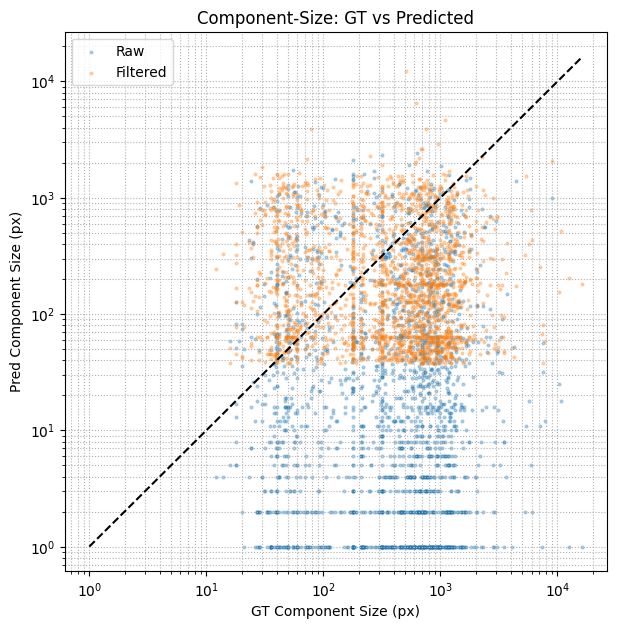

/tmp/ipykernel_785740/1693520529.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([gt_sizes, raw_sizes, filt_sizes],


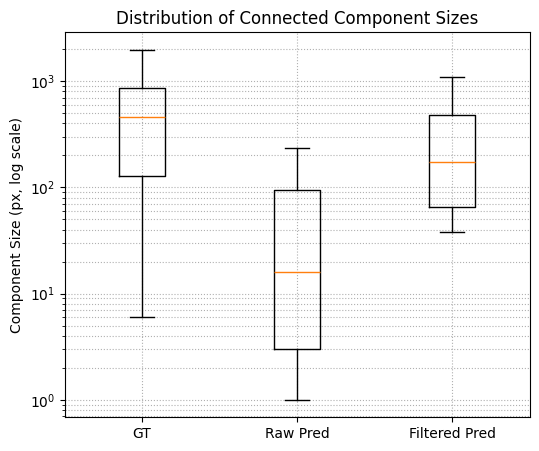

In [ ]:
# %% [markdown]
# Cell 10: Component-Size Comparison (Scatter & Boxplot)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Helper to flatten the list-columns
def flatten(col):
    return np.concatenate(col.apply(eval).values)

# Load CSVs
gt_df   = pd.read_csv("gt_mask_stats.csv")
pred_df = pd.read_csv("pred_mask_stats.csv")

# Flatten GT sizes and Predicted raw & filtered sizes
gt_sizes   = flatten(gt_df["component_sizes"])
raw_sizes  = flatten(pred_df["component_sizes_raw"])
filt_sizes = flatten(pred_df["component_sizes_filtered"])

# 1) Scatter: sample of GT vs Raw sizes
# (match them 1:1 up to min length for visualization)
n = min(len(gt_sizes), len(raw_sizes), 2000)
idx = np.random.choice(len(gt_sizes), n, replace=False)
plt.figure(figsize=(7,7))
plt.scatter(gt_sizes[idx], raw_sizes[idx], s=4, alpha=0.3, label="Raw")
plt.scatter(gt_sizes[idx], filt_sizes[idx], s=4, alpha=0.3, label="Filtered")
maxval = max(gt_sizes[idx].max(), raw_sizes[idx].max(), filt_sizes[idx].max())
plt.plot([1,maxval],[1,maxval],"k--")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("GT Component Size (px)")
plt.ylabel("Pred Component Size (px)")
plt.title("Component-Size: GT vs Predicted")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.show()

# 2) Boxplot: size distributions (log scale)
plt.figure(figsize=(6,5))
plt.boxplot([gt_sizes, raw_sizes, filt_sizes],
            labels=["GT","Raw Pred","Filtered Pred"],
            showfliers=False)
plt.yscale("log")
plt.ylabel("Component Size (px, log scale)")
plt.title("Distribution of Connected Component Sizes")
plt.grid(True, which="both", ls=":")
plt.show()


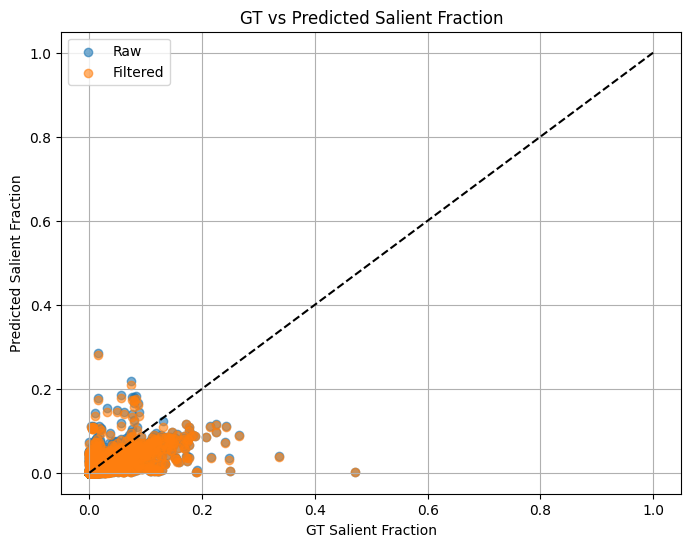

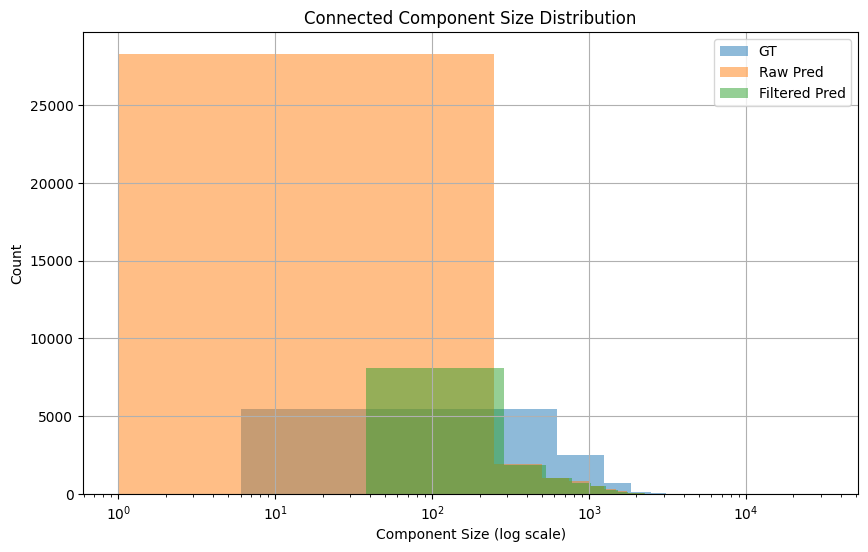

In [ ]:
# %% [markdown]
# Cell 8: Visualize GT vs Predicted Stats

import matplotlib.pyplot as plt

# Merge by index in order (assumes gt_stats_df order aligns with pred_bins order)
vis_df = gt_stats_df.copy().reset_index(drop=True)
vis_df["frac_pred_raw"] = pred_df["fraction_salient_raw"]
vis_df["frac_pred_filt"] = pred_df["fraction_salient_filtered"]

# 1) Salient fraction scatter
plt.figure(figsize=(8,6))
plt.scatter(vis_df["fraction_salient"], vis_df["frac_pred_raw"], alpha=0.6, label="Raw")
plt.scatter(vis_df["fraction_salient"], vis_df["frac_pred_filt"], alpha=0.6, label="Filtered")
plt.plot([0,1],[0,1], "k--")
plt.xlabel("GT Salient Fraction")
plt.ylabel("Predicted Salient Fraction")
plt.title("GT vs Predicted Salient Fraction")
plt.legend()
plt.grid(True)
plt.show()

# 2) Component size distributions
def flatten(lists): return [x for sub in lists for x in sub]

all_gt   = flatten(vis_df["component_sizes"])
all_raw  = flatten(pred_df["component_sizes_raw"])
all_filt = flatten(pred_df["component_sizes_filtered"])

plt.figure(figsize=(10,6))
plt.hist(all_gt, bins=50, alpha=0.5, label="GT")
plt.hist(all_raw, bins=50, alpha=0.5, label="Raw Pred")
plt.hist(all_filt, bins=50, alpha=0.5, label="Filtered Pred")
plt.xscale("log")
plt.xlabel("Component Size (log scale)")
plt.ylabel("Count")
plt.title("Connected Component Size Distribution")
plt.legend()
plt.grid(True)
plt.show()
